In [2]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50, VGG16
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt

In [3]:
# Load and preprocess the CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Normalize images to the range [0, 1]
x_train = x_train / 255.0
x_test = x_test / 255.0

# Convert labels to one-hot encoding
y_train = to_categorical(y_train, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 14s 0us/step


In [4]:
# Check the data shapes
print(f"x_train shape: {x_train.shape}, y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape}, y_test shape: {y_test.shape}")

x_train shape: (50000, 32, 32, 3), y_train shape: (50000, 10)
x_test shape: (10000, 32, 32, 3), y_test shape: (10000, 10)


In [5]:
# Define the model creation function
def create_model(base_model, num_classes):
    base_model.trainable = False  # Freeze the base model layers
    inputs = tf.keras.Input(shape=(32, 32, 3))
    x = base_model(inputs, training=False)  # Pass the input through the base model
    x = GlobalAveragePooling2D()(x)  # Reduce the spatial dimensions
    x = Dropout(0.5)(x)  # Dropout layer to avoid overfitting
    outputs = Dense(num_classes, activation='softmax')(x)  # Final classification layer
    model = Model(inputs, outputs)
    return model


In [6]:
# Load pre-trained ResNet50 and VGG16 without the top layers
resnet_base = ResNet50(weights='imagenet', include_top=False)
vgg16_base = VGG16(weights='imagenet', include_top=False)

# Create models using the pre-trained base models
resnet_model = create_model(resnet_base, num_classes=10)
vgg16_model = create_model(vgg16_base, num_classes=10)

# Compile the models
optimizer = Adam(learning_rate=0.001)

resnet_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
vgg16_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [7]:
# Load pre-trained ResNet50 and VGG16 without the top layers
resnet_base = ResNet50(weights='imagenet', include_top=False)
vgg16_base = VGG16(weights='imagenet', include_top=False)

# Create models using the pre-trained base models
resnet_model = create_model(resnet_base, num_classes=10)
vgg16_model = create_model(vgg16_base, num_classes=10)

# Compile the models
# Moved optimizer initialization AFTER model creation
optimizer_resnet = Adam(learning_rate=0.001)  # Optimizer for ResNet
optimizer_vgg16 = Adam(learning_rate=0.001)  # Optimizer for VGG16


resnet_model.compile(optimizer=optimizer_resnet, loss='categorical_crossentropy', metrics=['accuracy'])
vgg16_model.compile(optimizer=optimizer_vgg16, loss='categorical_crossentropy', metrics=['accuracy']) # Use separate optimizer for VGG16

In [8]:
# Train the ResNet-50 Model
print("Training ResNet-50 Model...")
resnet_history = resnet_model.fit(
    x_train, y_train, epochs=10, batch_size=32, validation_data=(x_test, y_test), verbose=1
)

# Train the VGG16 Model
print("Training VGG16 Model...")
vgg16_history = vgg16_model.fit(
    x_train, y_train, epochs=10, batch_size=32, validation_data=(x_test, y_test), verbose=1
)

Training ResNet-50 Model...
Epoch 1/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 32s 14ms/step - accuracy: 0.1541 - loss: 2.5710 - val_accuracy: 0.2833 - val_loss: 2.0171
Epoch 2/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 27s 8ms/step - accuracy: 0.2129 - loss: 2.1540 - val_accuracy: 0.2890 - val_loss: 1.9838
Epoch 3/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 20s 8ms/step - accuracy: 0.2217 - loss: 2.1305 - val_accuracy: 0.2687 - val_loss: 2.0090
Epoch 4/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 14s 9ms/step - accuracy: 0.2236 - loss: 2.1314 - val_accuracy: 0.2786 - val_loss: 2.0314
Epoch 5/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 20s 8ms/step - accuracy: 0.2268 - loss: 2.1303 - val_accuracy: 0.2708 - val_loss: 1.9817
Epoch 6/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 21s 9ms/step - accuracy: 0.2255 - loss: 2.1269 - val_accuracy: 0.2811 - val_loss: 1.9788
Epoch 7/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - accuracy: 0.2308 - loss: 2.1173 - val_accuracy: 0.2974 - val_loss: 1.9554
Epoch 8/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step

In [11]:
def fine_tune_model(model, base_model):
    base_model.trainable = True  # Unfreeze the base model layers
    model.compile(optimizer=Adam(learning_rate=0.0001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Fine-tune the models
resnet_model = fine_tune_model(resnet_model, resnet_base)
vgg16_model = fine_tune_model(vgg16_model, vgg16_base)

# Fine-tune for a few more epochs
print("Fine-tuning ResNet-50 Model...")
resnet_fine_history = resnet_model.fit(
    x_train, y_train, epochs=5, batch_size=32, validation_data=(x_test, y_test), verbose=1
)

print("Fine-tuning VGG16 Model...")
vgg16_fine_history = vgg16_model.fit(
    x_train, y_train, epochs=5, batch_size=32, validation_data=(x_test, y_test), verbose=1
)

Fine-tuning ResNet-50 Model...
Epoch 1/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 116s 43ms/step - accuracy: 0.7406 - loss: 0.9052 - val_accuracy: 0.7229 - val_loss: 0.8016
Epoch 2/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 48s 31ms/step - accuracy: 0.7453 - loss: 1.0101 - val_accuracy: 0.7870 - val_loss: 0.6477
Epoch 3/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 80s 30ms/step - accuracy: 0.8008 - loss: 0.6762 - val_accuracy: 0.7655 - val_loss: 1.3357
Epoch 4/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 82s 30ms/step - accuracy: 0.8158 - loss: 0.6289 - val_accuracy: 0.7982 - val_loss: 0.6501
Epoch 5/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 82s 30ms/step - accuracy: 0.8321 - loss: 0.5530 - val_accuracy: 0.6706 - val_loss: 3.7838
Fine-tuning VGG16 Model...
Epoch 1/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 63s 37ms/step - accuracy: 0.9535 - loss: 0.1477 - val_accuracy: 0.8550 - val_loss: 0.5043
Epoch 2/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 76s 34ms/step - accuracy: 0.9667 - loss: 0.1021 - val_accuracy: 0.8487 - val_loss: 0.6144
Epoch 3/5
1563/1563 ━━━━

In [14]:
# Evaluate ResNet-50 Model
print("Evaluating ResNet-50 Model...")
resnet_eval = resnet_model.evaluate(x_test, y_test, verbose=1)

# Evaluate VGG16 Model
print("Evaluating VGG16 Model...")
vgg16_eval = vgg16_model.evaluate(x_test, y_test, verbose=1)

# Classification Report for ResNet-50
y_pred_resnet = tf.argmax(resnet_model.predict(x_test), axis=-1).numpy()
# Convert y_test to the same format as y_pred_resnet (multiclass)
y_test_classes = tf.argmax(y_test, axis=-1).numpy()  # Assuming y_test is one-hot encoded
print("ResNet-50 Classification Report:")
print(classification_report(y_test_classes, y_pred_resnet)) # Use y_test_classes

# Classification Report for VGG16
y_pred_vgg16 = tf.argmax(vgg16_model.predict(x_test), axis=-1).numpy()
# Convert y_test to the same format as y_pred_vgg16 (multiclass)
y_test_classes = tf.argmax(y_test, axis=-1).numpy()  # Assuming y_test is one-hot encoded
print("VGG16 Classification Report:")
print(classification_report(y_test_classes, y_pred_vgg16)) # Use y_test_classes


Evaluating ResNet-50 Model...
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.6719 - loss: 3.7679
Evaluating VGG16 Model...
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.8631 - loss: 0.6249
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
ResNet-50 Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.81      0.75      1000
           1       0.56      0.43      0.49      1000
           2       0.69      0.67      0.68      1000
           3       0.58      0.54      0.56      1000
           4       0.68      0.69      0.68      1000
           5       0.70      0.63      0.66      1000
           6       0.75      0.84      0.79      1000
           7       0.71      0.56      0.63      1000
           8       0.88      0.76      0.81      1000
           9       0.53      0.78      0.63      1000

    accuracy                           0.67     10000
   macro avg       0.68      0.67      0.67     10000
weighted avg    

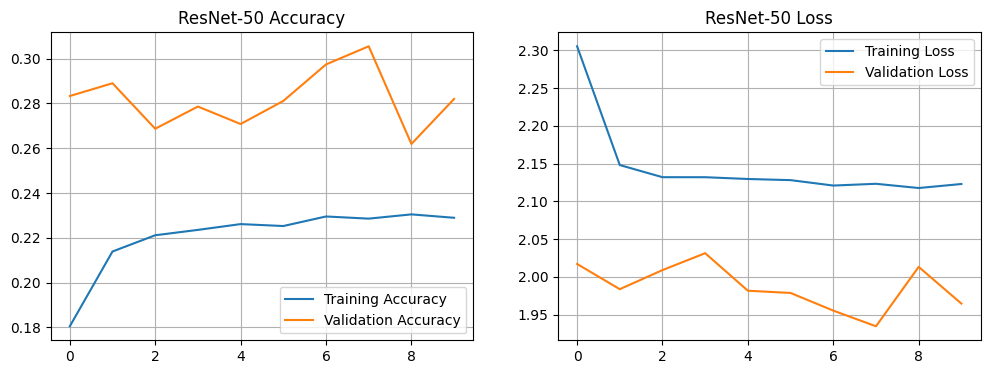

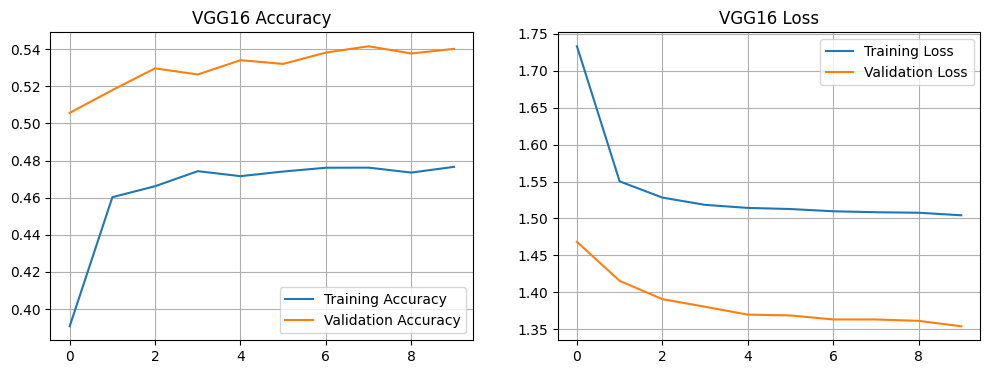

In [15]:
def plot_curves(history, title):
    plt.figure(figsize=(12, 4))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{title} Accuracy')
    plt.legend()
    plt.grid()

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{title} Loss')
    plt.legend()
    plt.grid()

    plt.show()

# Plot curves for ResNet-50 and VGG16
plot_curves(resnet_history, "ResNet-50")
plot_curves(vgg16_history, "VGG16")
